In [1]:
import pandas as pd
import yaml
import matplotlib.pyplot as plt
import seaborn as sns

from utils.dataset import Dataset
from utils.utils import *

import warnings
warnings.filterwarnings('ignore')

## Load Data

In [2]:
d = Dataset(path="Data/dataset_monthly.csv",
                date_col="Date",
                include_pct_change=True,
               )
d.data.loc[:, d.data.dtypes == 'O'] = d.data.loc[:, d.data.dtypes == 'O'].astype(bool)
d.data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 869 entries, 0 to 868
Data columns (total 73 columns):
 #   Column                                    Non-Null Count  Dtype         
---  ------                                    --------------  -----         
 0   Date                                      869 non-null    datetime64[ns]
 1   cpi_all_seas                              869 non-null    float64       
 2   cpi_all_unadj                             869 non-null    float64       
 3   cpi_energy_seas                           761 non-null    float64       
 4   cpi_energy_unadj                          761 non-null    float64       
 5   cpi_less_energy_seas                      761 non-null    float64       
 6   cpi_less_energy_unadj                     761 non-null    float64       
 7   empl_pop_ratio_seas                       869 non-null    float64       
 8   empl_pop_ratio_unadj                      869 non-null    float64       
 9   unempl_level_seas               

In [3]:
Y_cols = ["Fed_rate_month_avg", "Fed_rate_spot_EOM",
         "Fed_rate_month_avg_diff", "Fed_rate_month_avg_pct_change",
         "Fed_rate_month_avg_diff_3_class", "Fed_rate_month_avg_diff_5_class",
         "Fed_rate_month_avg_diff_9_class", "Fed_rate_month_avg_trend"
         ]
X_non_cols = ["Fed_rate_month_avg_diff_3_class", "Fed_rate_month_avg_diff_5_class",
              "Fed_rate_month_avg_diff_9_class", "Fed_rate_month_avg_trend"
             ]
X_cols = list(filter(lambda x: x not in X_non_cols, d.data.columns))

excl_cols = list(filter(lambda x: x.replace("_pct_change", "")[-5:] == "unadj", X_cols))
X_cols = list(filter(lambda x: x not in excl_cols, X_cols))

In [4]:
d.drop(excl_cols, inplace=True)
features_info = open_file("./config/features_info.yaml")

## Data visualization

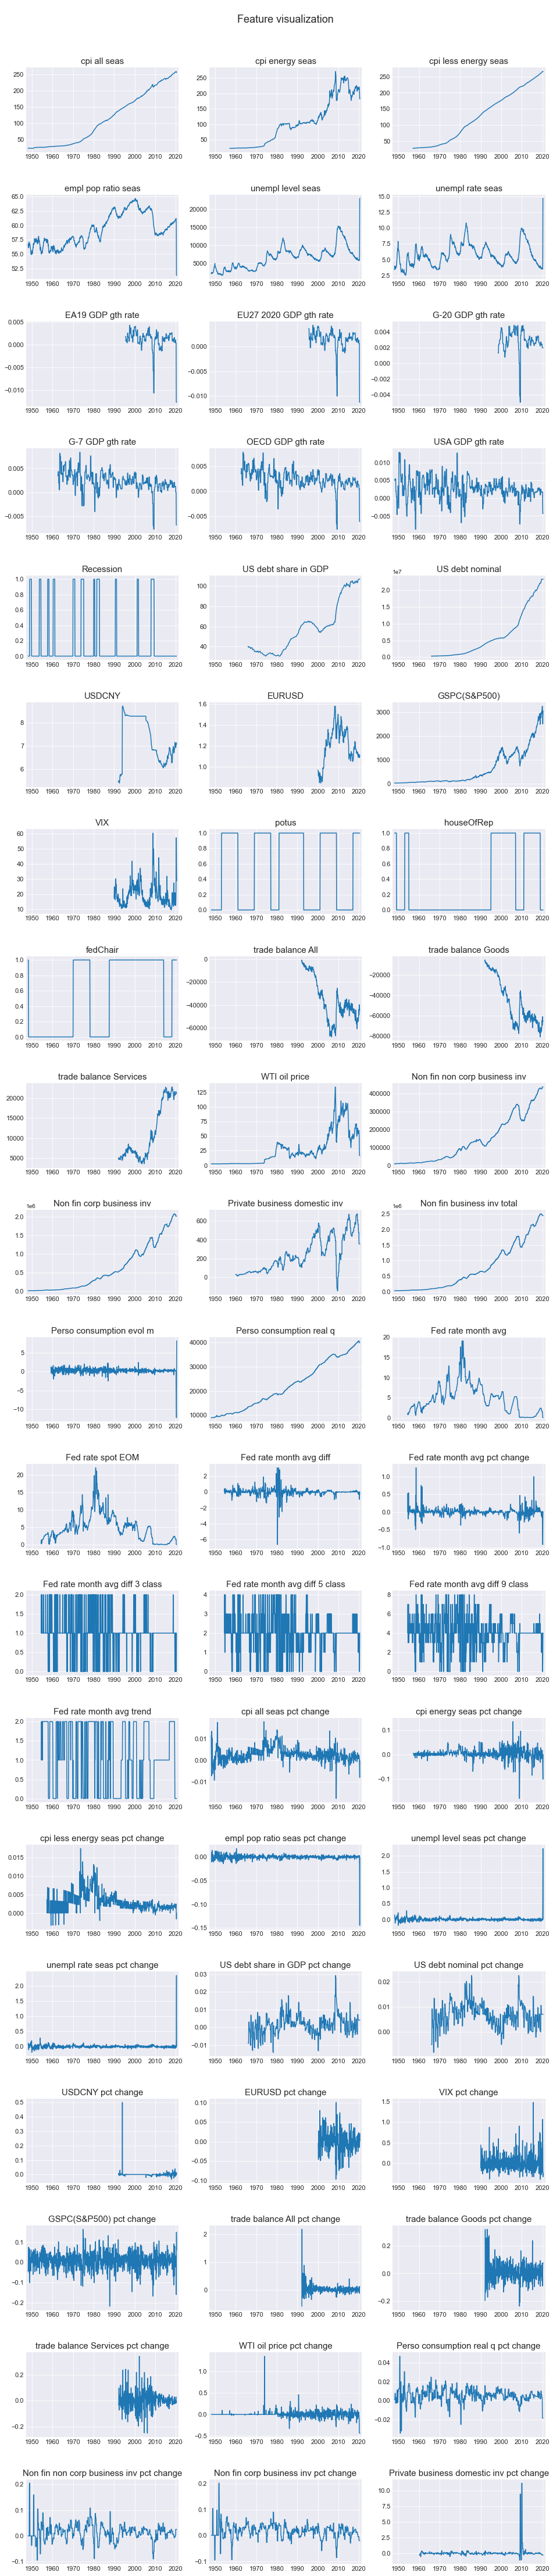

In [5]:
d.visualize_features(ncols=3,
                     height_per_ax=3
                    )

## Feature selection

### 1. Feature stationarity

#### Dickey-Fuller test to ensure stationarity of variables

https://medium.com/@stallonejacob/time-series-forecast-a-basic-introduction-using-python-414fcb963000

http://www.real-statistics.com/time-series-analysis/stochastic-processes/dickey-fuller-test/a

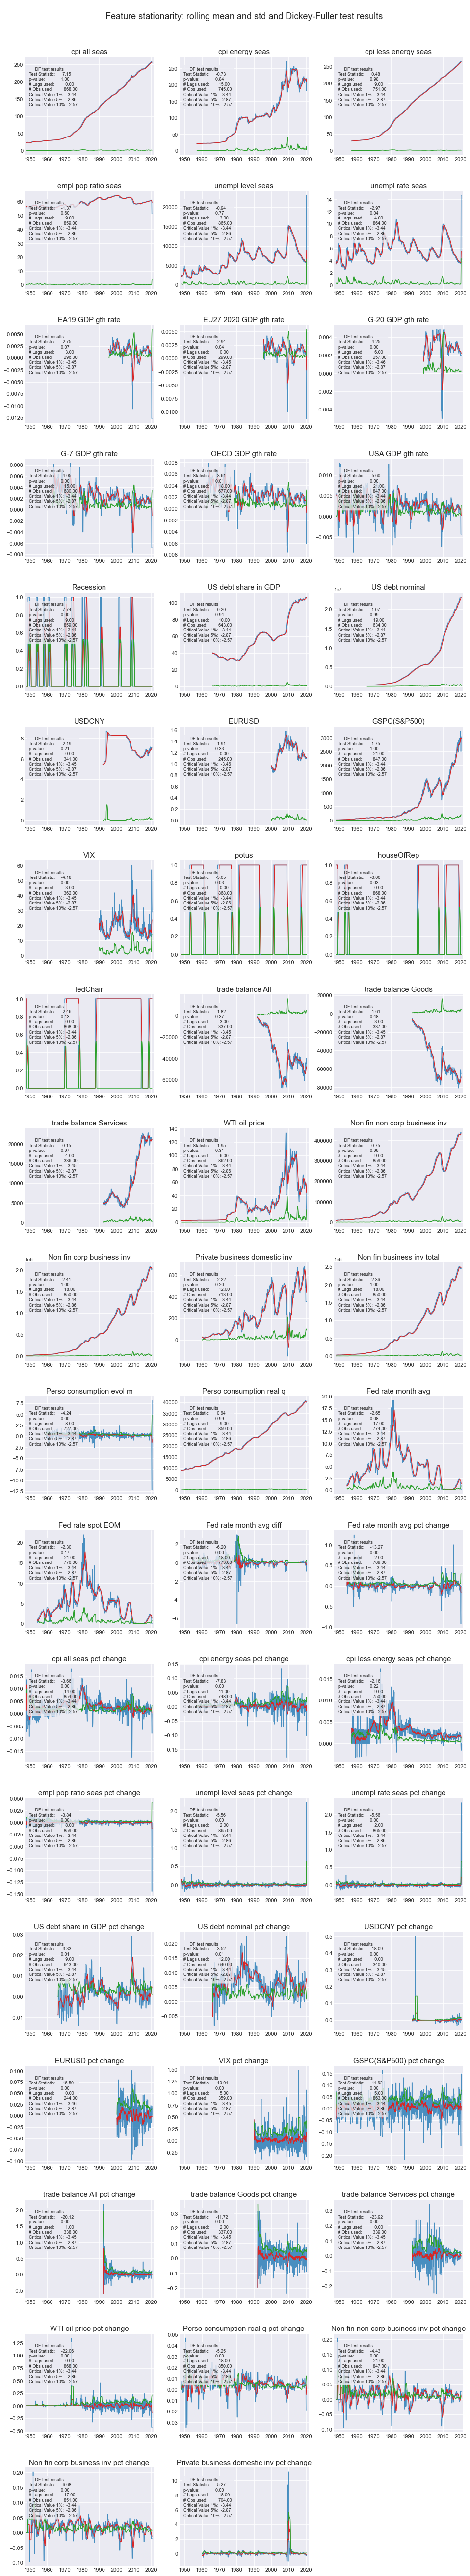

In [6]:
stat_results = d.test_stationarity(columns=X_cols,
                                   plot_test_results=True,
                                   ncols=3,
                                   height_per_ax=4,
                                  )

#### Take only stationary features, keep only one of original feature and "_pct_change"

In [7]:
_ = d.remove_non_stationary_features(stat_results,
                                     stat_conf_level="5%",
                                     excl_cols=Y_cols + features_info["categorical features"]
                                    )

------------------------------------- Non-stationarity: following features dropped -------------------------------------
cpi_all_seas
cpi_energy_seas
cpi_less_energy_seas
empl_pop_ratio_seas
unempl_level_seas
unempl_rate_seas_pct_change
EA19_GDP_gth_rate
US_debt_share_in_GDP
US_debt_nominal
USDCNY
EURUSD
GSPC(S&P500)
VIX_pct_change
trade_balance_All
trade_balance_Goods
trade_balance_Services
WTI_oil_price
Non_fin_non_corp_business_inv
Non_fin_corp_business_inv
Private_business_domestic_inv
Non_fin_business_inv_total
Perso_consumption_real_q
cpi_less_energy_seas_pct_change


### 2. Feature seasonality

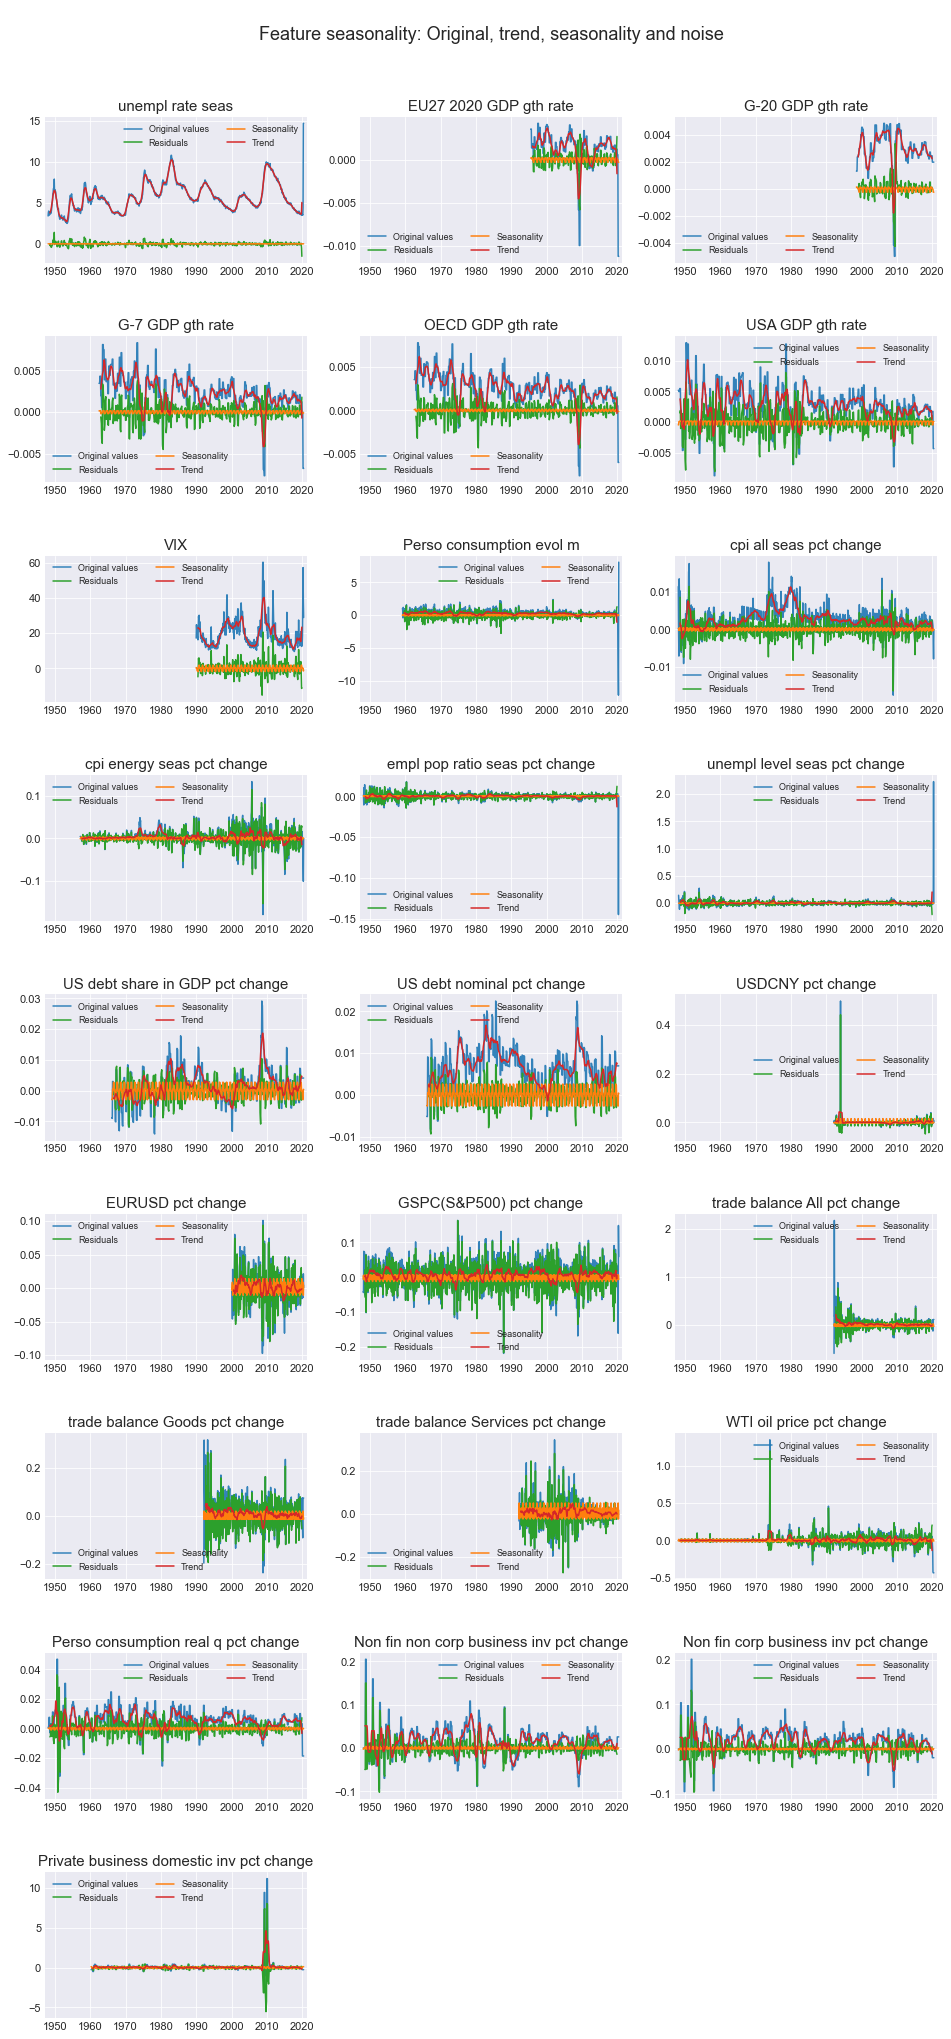

In [8]:
X_trend, X_seas, X_resid = d.test_seasonality(excl_cols=Y_cols + features_info["categorical features"],
                                              plot_graphs=True,
                                              ncols=3,
                                              height_per_ax=3
                                             )

In [9]:
_ = d.remove_seasonality(X_seas, threshold = 0.15)     

----------------------------------- Seasonality removed from the following features ------------------------------------
VIX
Perso_consumption_evol_m
cpi_energy_seas_pct_change
US_debt_share_in_GDP_pct_change
US_debt_nominal_pct_change
USDCNY_pct_change
EURUSD_pct_change
GSPC(S&P500)_pct_change
trade_balance_Goods_pct_change
trade_balance_Services_pct_change
WTI_oil_price_pct_change


### 3. Feature correlation

<class 'pandas.core.frame.DataFrame'>
Int64Index: 869 entries, 0 to 868
Data columns (total 38 columns):
 #   Column                                    Non-Null Count  Dtype         
---  ------                                    --------------  -----         
 0   Date                                      869 non-null    datetime64[ns]
 1   unempl_rate_seas                          869 non-null    float64       
 2   EU27_2020_GDP_gth_rate                    300 non-null    float64       
 3   G-20_GDP_gth_rate                         264 non-null    float64       
 4   G-7_GDP_gth_rate                          696 non-null    float64       
 5   OECD_GDP_gth_rate                         696 non-null    float64       
 6   USA_GDP_gth_rate                          869 non-null    float64       
 7   Recession                                 869 non-null    float64       
 8   VIX                                       366 non-null    float64       
 9   potus                           

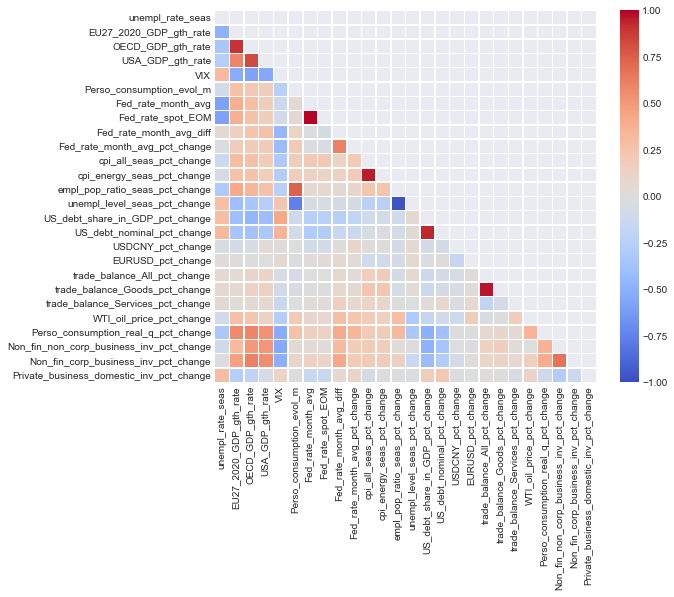

In [10]:
fig = plt.figure(figsize = (0.15 * len(X_cols), 0.12 * len(X_cols)))
print(d.data.info())
num_cols = [x for x in d.data.columns if x in features_info["numeric features"]]
corr = d.data.iloc[-245:][num_cols].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

heat_map = sns.heatmap(data=corr, mask=mask, cmap='coolwarm', linewidth=.5, vmin=-1, vmax=1)

## Save cleaned data

In [12]:
path = "./Data/"
files = {
    "cleaned_data.csv": d.data,
    "cleaned_data_params.yaml": d.params
}
save_files(path="./Data/", files=files, replace=True)

---------------------------------------- 2 file(s) saved succesfully in ./Data/ ----------------------------------------
